# Project 2: *Optimizing Realty Feature Selection for Highest Sales Price*

### Problem Statement
We are a home renovation company looking to pitch our garage, kitchen, basement and bathroom renovation services to a group of homeowners who are looking to increase the value of their properties in order to potentially sell their homes in the near future. Using historical assessment parameters collected by the Ames Housing Authority, we created a model that will recommend which features of a house would best increase the sales price of a house if renovated or built. However, this model was rather rudimentary and we would like to instead apply it to larger projects such as housing construction where we would like to earn a contract to constructing houses of a standardized style in a neighborhood. We are conducting this project in order to figure out what features of a house would yield the highest value for implementation in this future neighborhood project. 


### Executive Summary

###  Contents:
-[EDA](#EDA)
   * [Removing Outliers](#Removing-Recommended-Outliers-from-Data-Dictionary)
   * [Dealing with Null Values](#Dealing-with-Null-Values)  
-[Linear Regression](#Linear-Regression)  
-[Ridge Regression](#Ridge-Regression)  
-[Lasso Regression](#Lasso-Regression)  
-[Conclusion](#Conclusions)  
-[Sources](#Sources)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
%matplotlib inline
pd.options.display.max_rows = 4000

In [2]:
df_train = pd.read_csv('./datasets/train.csv')
df_test = pd.read_csv('./datasets/test.csv')

In [3]:
df_train.set_index('Id', inplace = True)
df_test.set_index('Id', inplace = True)

## EDA

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 109 to 10
Data columns (total 80 columns):
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         2051 non-null object
Roof Matl          2

This function will show the correlation of available features to sales price in order to help choose which features I want to include in the model and also focus my cleaning on. 

In [5]:
def corr_price(df = df_train, y = 'SalePrice', plot = False):
    data = df.corr()[[y]].sort_values(by = y, ascending = False)
    if plot == True:
        plt.figure(figsize = (6,12))
        sns.heatmap(data,
                    cmap = 'coolwarm', 
                    vmin = -1, vmax = 1,
                    annot = True)
        
    else: 
        return data

In [6]:
corr_price()

,SalePrice
SalePrice,1.000000
Overall Qual,0.800207
Gr Liv Area,0.697038
Garage Area,0.650270
Garage Cars,0.648220
Total Bsmt SF,0.628925
1st Flr SF,0.618486
Year Built,0.571849
Year Remod/Add,0.550370
Full Bath,0.537969


### Removing Recommended Outliers from Data Dictionary
- The data dictionary recommended to remove houses with an groung living square footage > 4000 ft<sup>2</sup> from the data set in order to eliminate 2 outliers from the dataset representing unusual sales of very large houses sold at uncharacteristically low prices.

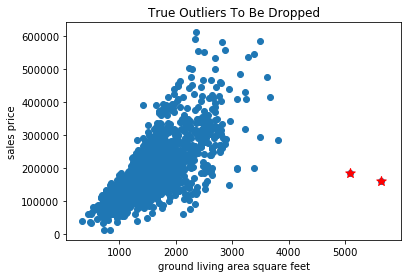

In [7]:
y = df_train['SalePrice']
x = df_train['Gr Liv Area']
plt.tight_layout;
plt.scatter(df_train['Gr Liv Area'], df_train['SalePrice'])
plt.xlabel("ground living area square feet");
plt.ylabel('sales price');
plt.scatter(df_train.loc[df_train['Gr Liv Area'] > 4000,['Gr Liv Area']],
            df_train.loc[df_train['Gr Liv Area'] > 4000,['SalePrice']], 
            marker = '*',
            s = 100,
            c = 'Red')
plt.title('True Outliers To Be Dropped');

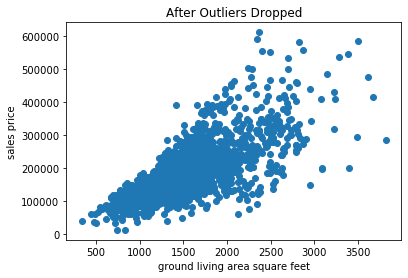

In [8]:
#Dropping Outliers
df_train.drop(df_train.loc[df_train['Gr Liv Area'] > 4000].index, inplace = True)

plt.scatter(df_train['Gr Liv Area'], df_train['SalePrice'])
plt.xlabel("ground living area square feet");
plt.ylabel('sales price');
plt.title('After Outliers Dropped');
plt.tight_layout;

### Dealing with Null Values

- ### Ordinal Data Cleaning

Ordinal data is similar to Nominal data except that each categorical value in a column does not represent the same numerical value as the other values in the column. For example, the `Pool QC` column lists values that describe the quality of the pool on a property which means a value of `Ex`(Excellent) should not be considered the same as a value of `Fa`(Fair). Therefore, binarizing this column in a regression would not work because there are incremental relationships between each value in the column. Therefore, I changed `Ex` to 4, and gave each value a numerical value of 1 less so that the regression model will show that a value of `EX`(4) will have a proportionally larger effect than a value of `Fa`(1). The assumption being made is that each rank has a linear incremental relationship with the other meaning that the a rank of Excellent(4) is exactly one unit of quality better than the rank of Good(3) and so on until Fair(1). In reality this scale can be further improved but is appropriately generalized for a linear model. In columns such as `Pool QC` and `Fireplace QU` where null values of `NA` represented the lack of a relevant features existence (No Pool, or No Fireplace to be scored), I replaced the null values with 0 so that the model would show no effect as a result of these features. Going down the data dictionary I did this for all ordinal variables with a ranking nomenclature in place that wasn't already numerically represented. 

In [9]:
com_rank = {'ex_qual':{'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
            'ex_qual_na': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0}}

In [10]:
Ordinal_ranks = {'Utilities': {'AllPub':4, 'NoSewr':3, 'NoSeWa':2, 'ELO':1},
                 'Land Slope': {'Gtl': 3, 'Mod': 2, 'Sev': 1},                                     
                 'Exter Qual': com_rank['ex_qual'],                                    
                 'Exter Cond' : com_rank['ex_qual'],
                 'Bsmt Qual': com_rank['ex_qual_na'],                    
                 'Bsmt Cond': com_rank['ex_qual_na'],                                    
                 'Bsmt Exposure':{'Gd': 4,'Av':3,'Mn': 2,'No': 1, np.nan: 0},                                    
                 'BsmtFin Type 1': {'GLQ': 6, 'ALQ': 5,'BLQ': 4,'Rec': 3, 'LwQ': 2, 'Unf': 1, np.nan: 0},  
                 'BsmtFin Type 2': {'GLQ': 6, 'ALQ': 5,'BLQ': 4,'Rec': 3, 'LwQ': 2, 'Unf': 1, np.nan: 0},
                 'HeatingQC': com_rank['ex_qual'],
                 'Electrical': {'SBrkr': 4,'FuseA': 3, 'FuseF': 2, 'FuseP':1, 'Mix':0, np.nan: 0},
                 'Kitchen Qual': com_rank['ex_qual'],
                 'Functional': {'Typ':8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1},
                 'Fireplace Qu': com_rank['ex_qual_na'],
                 'Garage Finish': {'Fin': 3, 'RFn': 2, 'Unf': 1, np.nan: 0},
                 'Garage Qual': com_rank['ex_qual_na'],
                 'Garage Cond': com_rank['ex_qual_na'],
                 'Paved Drive': {'Y':3, 'P':2, 'N':1},
                 'Pool QC': {'Ex':4,'Gd':3,'TA':2,'Fa':1, np.nan:0},
                 'Fence': {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw':1, np.nan: 0},
                 'Lot Shape': {'Reg':4,'IR1':3,'IR2':2,'IR3':1}}

In [11]:
df_train.replace(Ordinal_ranks, inplace = True)
df_test.replace(Ordinal_ranks, inplace = True)

**The function below will return the # of null values in a column from largest to smallest**

In [12]:
def null_rank(df = df_train,count = 20):
    return df.isnull().sum().sort_values(ascending = False).head(count)

In [13]:
null_rank()

Misc Feature      1985
Alley             1909
Lot Frontage       330
Garage Yr Blt      114
Garage Type        113
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Full Bath       2
Bsmt Half Bath       2
Garage Area          1
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Garage Cars          1
BsmtFin SF 1         1
SalePrice            0
Exterior 1st         0
Exterior 2nd         0
Exter Qual           0
Roof Style           0
dtype: int64

### Nominal Data Cleaning

#### Checking Nominal Variable Columns with NaNs for false NaNs

This function will check whether there are any false null values created through human error. This will help for checking through columns that have a NA categorical value.

In [14]:
def null_values(column = 'MS Zoning', df = df_train):
    return df[column].value_counts(dropna = False)

- **Alley**

In [15]:
null_values('Alley')   

NaN     1909
Grvl      85
Pave      55
Name: Alley, dtype: int64

Its ok to convert all NaN values to 'Absent' in the Alley column because there is no other column to verify the existence of an Alley. Therefore, we can only trust the data dictionary.

In [16]:
df_train['Alley'].fillna('Absent', inplace = True) #Replace NaNs with 'Absent' to make dummifying easier later
df_test['Alley'].fillna('Absent', inplace = True)

In [17]:
null_values('Alley')

Absent    1909
Grvl        85
Pave        55
Name: Alley, dtype: int64

- **Garage Type**

In [18]:
null_values('Garage Type')

Attchd     1211
Detchd      536
BuiltIn     132
NaN         113
Basment      27
2Types       19
CarPort      11
Name: Garage Type, dtype: int64

Checking to see if NaN values are representative of houses without garages. 

In [19]:
df_train.loc[(df_train['Garage Type'].isnull()) & (df_train['Garage Area'] > 0),['Garage Area']].count()

Garage Area    0
dtype: int64

All the rows where Garage Type is null are associated with Garage Area = 0. 

In [20]:
df_train.loc[(df_train['Garage Type'].isnull()) & (df_train['Garage Area'] == 0),['Garage Area']].count()

Garage Area    113
dtype: int64

In [21]:
df_train['Garage Type'].fillna('Absent', inplace = True)
df_test['Garage Type'].fillna('Absent', inplace = True)

In [22]:
null_values('Garage Type')

Attchd     1211
Detchd      536
BuiltIn     132
Absent      113
Basment      27
2Types       19
CarPort      11
Name: Garage Type, dtype: int64

- **Masonic Veneer Type**: Follows the same logic as `Garage Type`

In [23]:
null_values('Mas Vnr Type')

None       1218
BrkFace     630
Stone       166
NaN          22
BrkCmn       13
Name: Mas Vnr Type, dtype: int64

In [24]:
df_train.loc[(df_train['Mas Vnr Type'].isnull()) & (df_train['Mas Vnr Area'] == 0),['Mas Vnr Area']].count()

Mas Vnr Area    0
dtype: int64

In [25]:
df_train['Mas Vnr Type'].fillna('Absent', inplace = True)
df_test['Mas Vnr Type'].fillna('Absent', inplace = True)

In [26]:
df_train['Mas Vnr Type'].replace('None','Absent', inplace = True)
df_test['Mas Vnr Type'].replace('None','Absent', inplace = True)

In [27]:
null_values('Mas Vnr Type')

Absent     1240
BrkFace     630
Stone       166
BrkCmn       13
Name: Mas Vnr Type, dtype: int64

- **Miscellaneous Feature**: Follows the same logic as `Garage Type`

In [28]:
null_values('Misc Feature')

NaN     1985
Shed      56
Gar2       4
Othr       3
TenC       1
Name: Misc Feature, dtype: int64

In [29]:
df_train.loc[(df_train['Misc Feature'].isnull()) & (df_train['Misc Val'] == 0),['Misc Val']].count()

Misc Val    1985
dtype: int64

In [30]:
df_train['Misc Feature'].fillna('Absent', inplace = True)
df_test['Misc Feature'].fillna('Absent', inplace = True)

In [31]:
null_values('Misc Feature')

Absent    1985
Shed        56
Gar2         4
Othr         3
TenC         1
Name: Misc Feature, dtype: int64

### Numerical Data Cleaning 

In [32]:
null_rank()

Lot Frontage      330
Garage Yr Blt     114
Mas Vnr Area       22
Bsmt Full Bath      2
Bsmt Half Bath      2
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
BsmtFin SF 1        1
Garage Cars         1
Garage Area         1
Roof Matl           0
Exterior 1st        0
Exterior 2nd        0
Mas Vnr Type        0
Exter Qual          0
Year Remod/Add      0
Exter Cond          0
Foundation          0
Bsmt Qual           0
dtype: int64

In [33]:
null_rank(df_test, count = 5)

Lot Frontage     160
Garage Yr Blt     45
Mas Vnr Area       1
Sale Type          0
Exter Cond         0
dtype: int64

- **Lot Frontage**

There are rows where Lot Frontage is a null value but there are no rows where Lot Frontage is 0. This leads me to believe that the null values are actually meant to represent 0s. The same logic will be valid for the test dataset.

In [34]:
df_train.loc[(df_train['Lot Frontage'] == 0),['Lot Frontage']].count()

Lot Frontage    0
dtype: int64

In [35]:
df_test.loc[(df_test['Lot Frontage'] == 0),['Lot Frontage']].count()

Lot Frontage    0
dtype: int64

In [36]:
df_train['Lot Frontage'].fillna(0,inplace= True)
df_test['Lot Frontage'].fillna(0,inplace= True)

- **Garage Year Built**

I decided I would not use this variable as a feature so I will replace null values with 0s indiscriminantly.

In [37]:
df_train['Garage Yr Blt'].fillna(0, inplace = True)
df_test['Garage Yr Blt'].fillna(0, inplace = True)

- **Masonic Veneer Area**

In [38]:
null_rank()

Mas Vnr Area      22
Bsmt Full Bath     2
Bsmt Half Bath     2
BsmtFin SF 2       1
Garage Cars        1
Garage Area        1
Bsmt Unf SF        1
BsmtFin SF 1       1
Total Bsmt SF      1
Bsmt Cond          0
Bsmt Qual          0
Foundation         0
Exter Cond         0
Year Remod/Add     0
Bsmt Exposure      0
Exter Qual         0
BsmtFin Type 1     0
Mas Vnr Type       0
Exterior 2nd       0
BsmtFin Type 2     0
dtype: int64

Trusting the ordinal variable descriptions in the data dictionary, I can replace the null values with 0s. The same logic will be valid for any remaining discrete and continuous variables with associated nominal variables. 

In [39]:
df_train.loc[df_train['Mas Vnr Area'].isnull(),['Mas Vnr Area','Mas Vnr Type']].head()

,Mas Vnr Area,Mas Vnr Type
Id,,
2393,NaN,Absent
2383,NaN,Absent
539,NaN,Absent
518,NaN,Absent
2824,NaN,Absent


In [40]:
df_train['Mas Vnr Area'].fillna(0, inplace = True)
df_test['Mas Vnr Area'].fillna(0, inplace = True)

- **Bsmt Full Bath and Bsmt Half Bath**

In [41]:
df_train.loc[df_train['Bsmt Full Bath'].isnull(),['Bsmt Half Bath']]

,Bsmt Half Bath
Id,
1498,NaN
1342,NaN


In [42]:
df_train['Bsmt Full Bath'].fillna(0, inplace = True)
df_train['Bsmt Half Bath'].fillna(0, inplace = True)
df_test['Bsmt Full Bath'].fillna(0, inplace = True)
df_test['Bsmt Half Bath'].fillna(0, inplace = True)

In [43]:
null_rank()

Bsmt Unf SF       1
BsmtFin SF 2      1
Total Bsmt SF     1
BsmtFin SF 1      1
Garage Cars       1
Garage Area       1
Mas Vnr Area      0
Roof Style        0
Roof Matl         0
Exterior 1st      0
Exterior 2nd      0
Mas Vnr Type      0
Exter Qual        0
Year Built        0
Exter Cond        0
Foundation        0
Bsmt Qual         0
Bsmt Cond         0
Bsmt Exposure     0
BsmtFin Type 1    0
dtype: int64

Remaining variables are associated with each other and have equal null values so I will replace them with 0s.

In [44]:
df_train.fillna({'Total Bsmt SF': 0,
                 'BsmtFin SF 1': 0,
                 'Garage Cars':0,
                 'Garage Area': 0,
                 'Bsmt Unf SF': 0,
                 'BsmtFin SF 2': 0}, inplace = True)

In [45]:
null_rank(df_train)

SalePrice         0
Sale Type         0
Roof Style        0
Roof Matl         0
Exterior 1st      0
Exterior 2nd      0
Mas Vnr Type      0
Mas Vnr Area      0
Exter Qual        0
Exter Cond        0
Foundation        0
Bsmt Qual         0
Bsmt Cond         0
Bsmt Exposure     0
BsmtFin Type 1    0
BsmtFin SF 1      0
BsmtFin Type 2    0
BsmtFin SF 2      0
Bsmt Unf SF       0
Year Remod/Add    0
dtype: int64

## Dummifying Nominal Variables

In [46]:
nominal_vars = ['MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config', 'Neighborhood',
               'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style','Roof Matl',
               'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air',
               'Garage Type', 'Misc Feature', 'Sale Type']
df_train = pd.get_dummies(df_train,columns = nominal_vars)
df_test = pd.get_dummies(df_test,columns = nominal_vars)

Once we dummify the train and test datasets, I have to make sure that both columns have the same columns as the other so that the regression can run smoothly. 

In [47]:
in_train_not_test = set(df_train.drop(columns = 'SalePrice')) - set(df_test)
in_test_not_train = set(df_test) - set(df_train.drop(columns = 'SalePrice'))

In [48]:
for col in in_train_not_test:
    df_test[col] = 0
for col in in_test_not_train:
    df_train[col] = 0 

In [49]:
for dummy in nominal_vars:
    col_list = [col for col in df_train.columns if dummy in col]
    df_train.drop(columns = col_list[0], inplace = True)
    df_test.drop(columns = col_list[0], inplace = True)

- Converting final dtypes to necessary numerical values

In [50]:
df_train.dtypes.value_counts()

uint8      138
int64       51
float64     11
object       4
dtype: int64

In [51]:
# Convert all remaining objects to ints
df_train.Utilities = df_train.Utilities.astype(int)
df_train['Kitchen Qual'] = df_train['Kitchen Qual'].astype(int)
df_train['Lot Shape'] = df_train['Lot Shape'].astype(int)
df_train['Electrical'] = df_train['Electrical'].astype(int)
df_train['Exter Qual'] = df_train['Exter Qual'].astype(int)
df_test.Utilities = df_test.Utilities.astype(int)
df_test['Kitchen Qual'] = df_test['Kitchen Qual'].astype(int)
df_test['Lot Shape'] = df_test['Lot Shape'].astype(int)
df_test['Electrical'] = df_test['Electrical'].astype(int)
df_test['Exter Qual'] = df_test['Exter Qual'].astype(int)

In [52]:
df_train.dtypes.value_counts()

uint8      138
int64       50
float64     11
int32        5
dtype: int64

In [53]:
df_test.dtypes.sort_values(ascending = False)

Functional               object
Lot Frontage            float64
Garage Yr Blt           float64
Mas Vnr Area            float64
Roof Matl_Membran         int64
Garage Cond               int64
Kitchen AbvGr             int64
TotRms AbvGrd             int64
Fireplaces                int64
Fireplace Qu              int64
Garage Finish             int64
Garage Cars               int64
Garage Area               int64
Garage Qual               int64
Wood Deck SF              int64
Paved Drive               int64
Half Bath                 int64
Open Porch SF             int64
Enclosed Porch            int64
3Ssn Porch                int64
Screen Porch              int64
Pool Area                 int64
Pool QC                   int64
Fence                     int64
Misc Val                  int64
Mo Sold                   int64
Bedroom AbvGr             int64
Bsmt Half Bath            int64
Full Bath                 int64
Bsmt Exposure             int64
MS SubClass               int64
Lot Area

In [54]:
df_test['Functional'] = df_test['Functional'].astype(int)
df_test.dtypes.value_counts()

uint8      132
int64       62
int32        6
float64      3
dtype: int64

- **Saving clean datasets**

In [55]:
df_train.to_csv('./datasets/train_clean.csv')
df_test.to_csv('./datasets/test_clean.csv')

### Linear Regression

In [56]:
#Setting up all feature inputs and output for Linreg
corr_df = df_train.corr()[['SalePrice']]
features = list(df_train[list(corr_df[['SalePrice']].notnull().sort_values(by = 'SalePrice', ascending = False).index)].drop(columns = ['SalePrice', 'PID']).columns)
X = df_train[features] 
y = df_train['SalePrice']

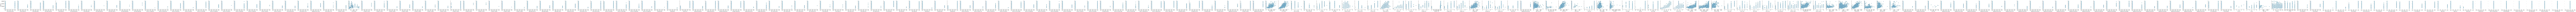

In [57]:
sns.pairplot(df_train, x_vars = features, y_vars = ['SalePrice']);

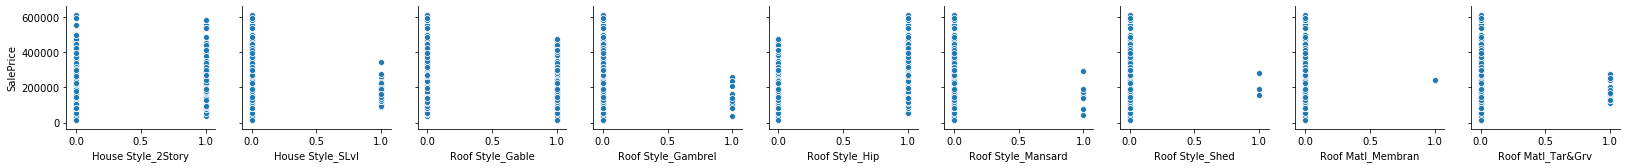

In [58]:
sns.pairplot(df_train, x_vars = features[:9], y_vars = ['SalePrice']);

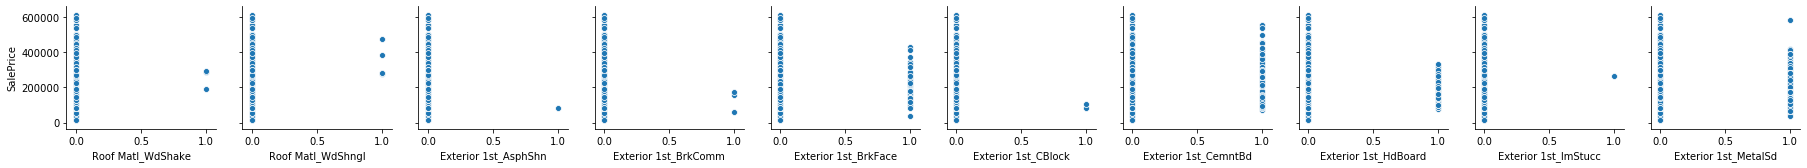

In [59]:
sns.pairplot(df_train, x_vars = features[9:19], y_vars = ['SalePrice'])

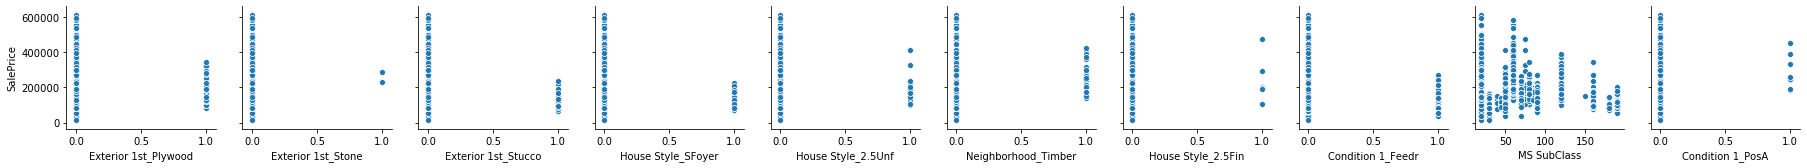

In [60]:
sns.pairplot(df_train, x_vars = features[19:29], y_vars = ['SalePrice'])

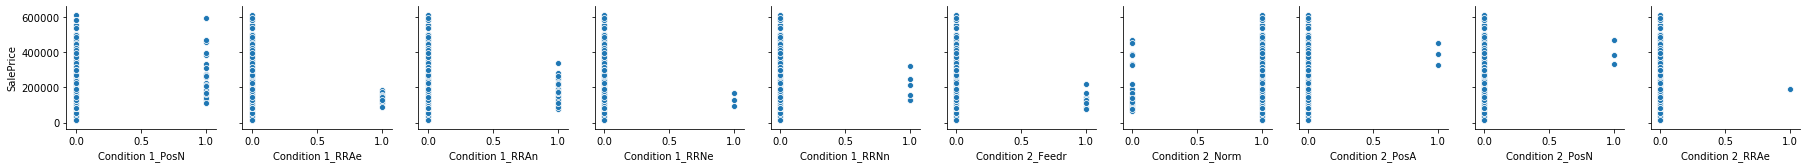

In [61]:
sns.pairplot(df_train, x_vars = features[29:39], y_vars = ['SalePrice'])

In [62]:
def corr_price(df = df_train, y = 'SalePrice', plot = False, ):
    data = df.corr()[[y]].sort_values(by = y, ascending = False)
    if plot == True:
        plt.figure(figsize = (6,12))
        sns.heatmap(data,
                    cmap = 'coolwarm', 
                    vmin = -1, vmax = 1,
                    annot = True)
        
    else: 
        return data

In [63]:
corr_price(df = df_train)

,SalePrice
SalePrice,1.000000
Overall Qual,0.803462
Gr Liv Area,0.719463
Exter Qual,0.715048
Kitchen Qual,0.694295
Total Bsmt SF,0.665116
Garage Area,0.655097
1st Flr SF,0.648252
Garage Cars,0.648227
Bsmt Qual,0.613236


- I am running the linear regression on all features that are not null in order to get the effect of every feature on the model.

In [64]:
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

In [65]:
#### BASELINE MODEL (to compare results with)

mean_y = y_train.mean()
y_preds_baseline = [mean_y for _ in y_train]

mean_squared_error(y_train, y_preds_baseline)**0.5

79197.86271412448

In [66]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

 - The cross validation scores show that the linear regression model has low bias and low variance which is the ideal model. 

In [67]:
cross_val_score(lr, X_train, y_train, cv = 5).mean()

0.8911057262889702

In [68]:
cross_val_score(lr, X_test,y_test, cv = 5).mean()

0.8482336607884454

- The chart below shows how well the linear regressions predictors follow the true values. 

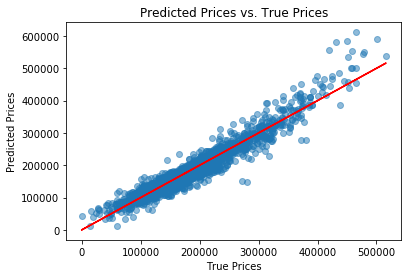

In [69]:
y_pred = lr.predict(X);
plt.scatter(y_pred, y, alpha = .5)
plt.title('Predicted Prices vs. True Prices');
plt.xlabel('True Prices');
plt.ylabel('Predicted Prices');
plt.plot(y_pred, y_pred, color = 'red');
plt.tight_layout;

 - There is light heteroskedasticity but other than that model predicts the true values with relatively minimal variance.

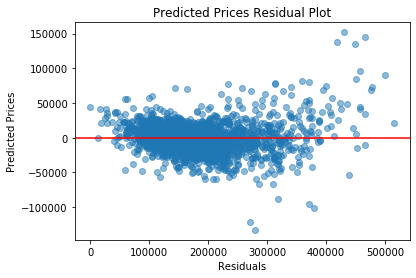

In [70]:
y_pred = lr.predict(X);
plt.scatter(y_pred,y-y_pred, alpha = .5);
plt.title('Predicted Prices Residual Plot');
plt.xlabel('Residuals');
plt.ylabel('Predicted Prices');
plt.axhline(color = 'Red');
plt.tight_layout;

In [71]:
df_coef = pd.DataFrame({'column': X.columns,'coef':lr.coef_})

In [72]:
df_coef.set_index('column', inplace = True)

In [73]:
df_coef = df_coef.sort_values( by = 'coef') #sorts beta 1 coefficients from smallest to largest. 

The chart below shows the features whose positive coefficients increase the slope of the model, and the features with negative coefficients that decrease the slope of the model.

In [74]:
df_coef

,coef
column,
Exterior 1st_BrkComm,-6.023232e+04
Exterior 1st_ImStucc,-4.193535e+04
Misc Feature_TenC,-4.158498e+04
Roof Style_Mansard,-4.087909e+04
Exterior 1st_Stone,-4.008707e+04
Heating_OthW,-3.343191e+04
Sale Type_ConLI,-3.199812e+04
Exterior 1st_AsphShn,-2.686194e+04
Exterior 1st_Wd Sdng,-2.563951e+04


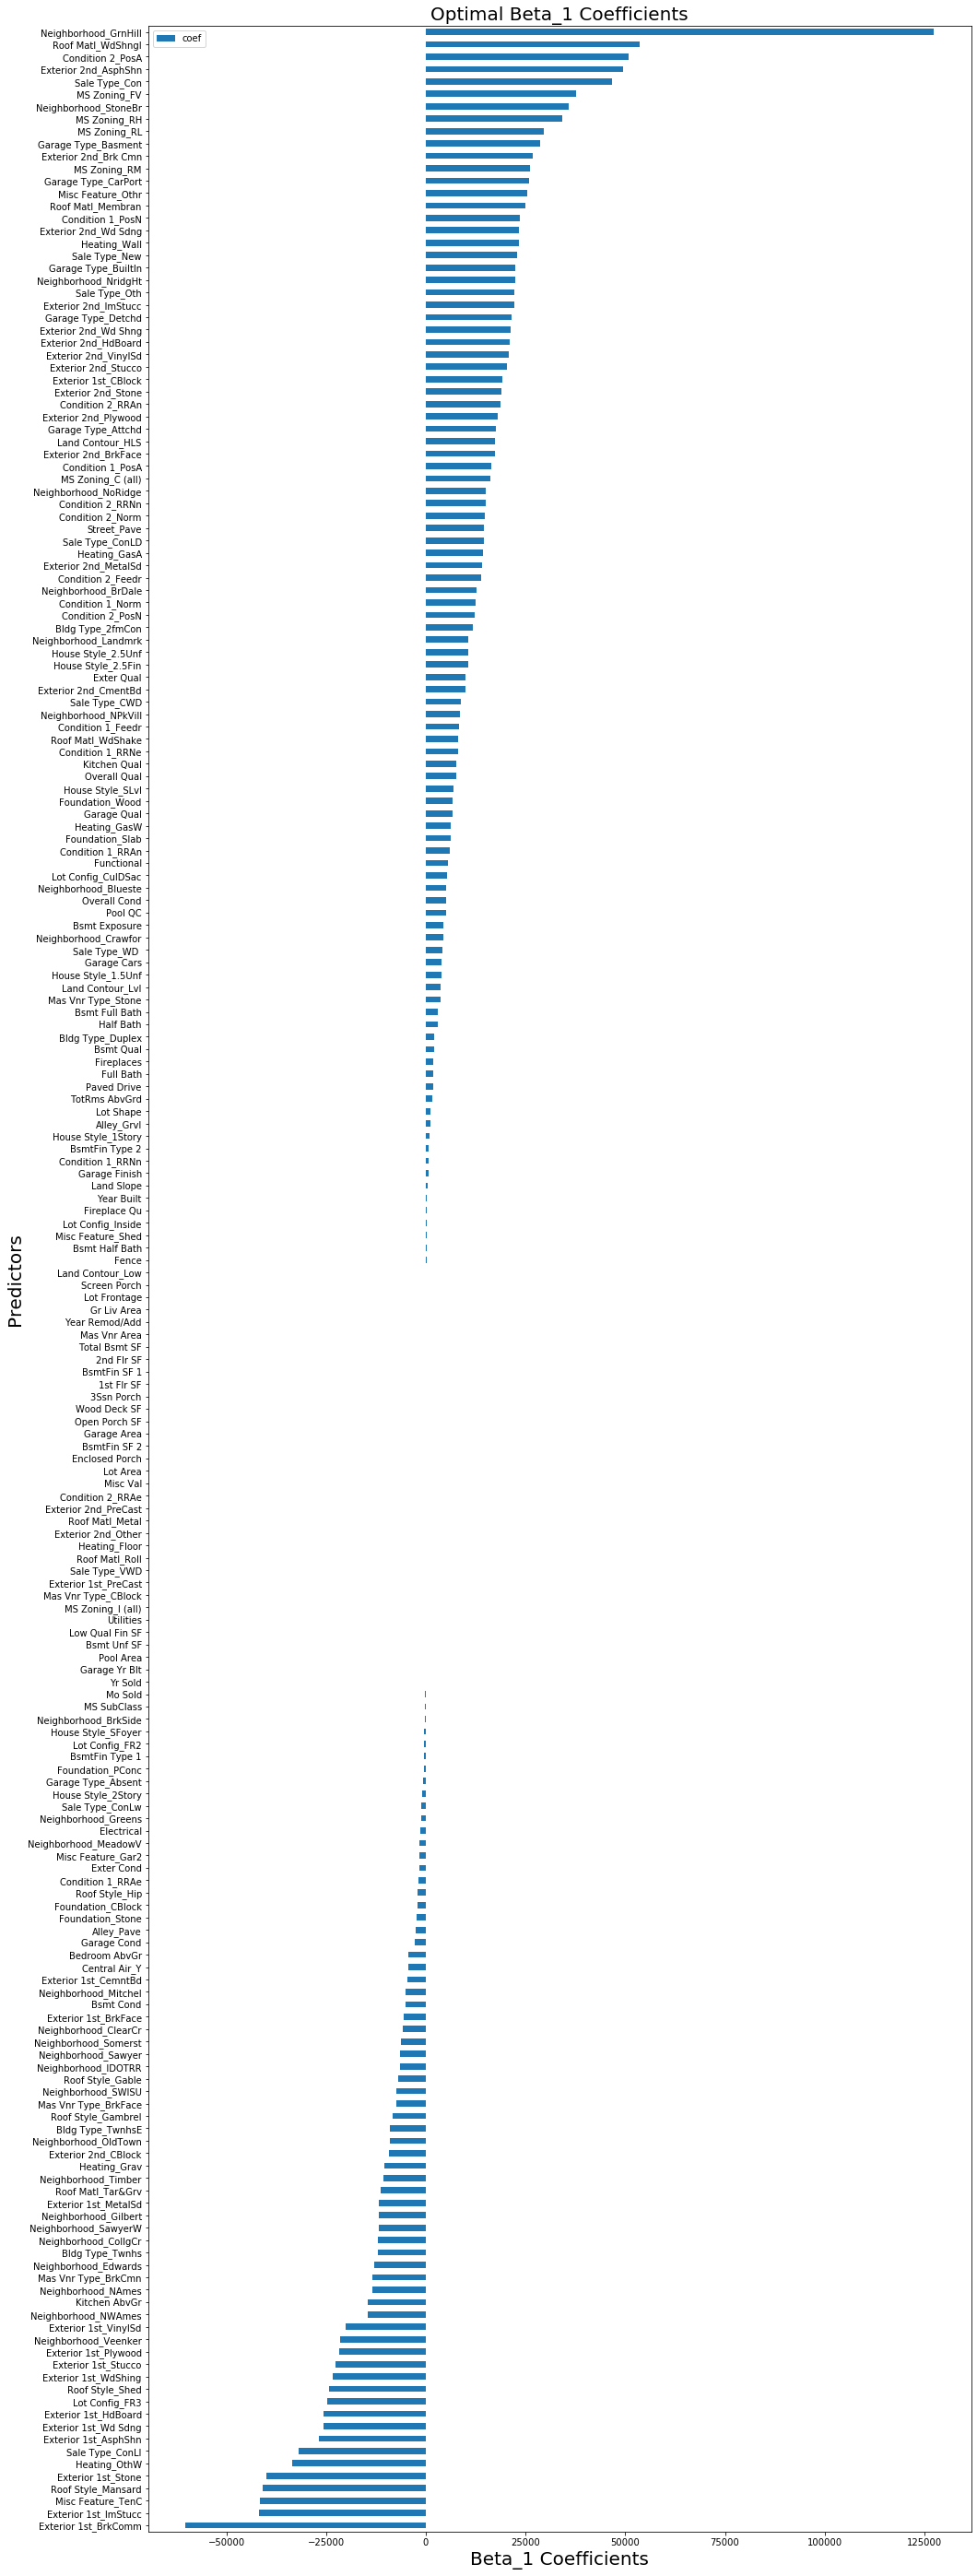

In [75]:
df_coef.plot(kind = 'barh', figsize = (16,50))
plt.title('Optimal Beta_1 Coefficients',fontsize = 20);
plt.ylabel('Predictors', fontsize = '20');
plt.xlabel('Beta_1 Coefficients', fontsize = '20');

### Ridge Regression

In [76]:
# Instantiate Standard Scaler
ss = StandardScaler()
# Fit and transform
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test) 

The ridge regression model adds a penalty term: $$ \alpha \sum_{j=1}^p \beta_j^2$$  
What this does is reduces the magnitude of the coefficients which in turn reduces the residual sum of squares the larger the alpha constant is and therefore optimizes the R^2. 

In [77]:
ridgecv = RidgeCV(alphas = np.logspace(-3,1, 100))
ridgecv.fit(Z_train, y_train)
ridgecv.score(Z_train,y_train)

0.9294982595381641

In [78]:
ridgecv.alpha_

10.0

In [79]:
ridge_model = Ridge(alpha = ridgecv.alpha_ , random_state = 42)
ridge_model.fit(Z_train, y_train)

print(f'ridge training score:{ridge_model.score(Z_train, y_train)}')
print(f'ridge test score: {ridge_model.score(Z_test, y_test)}')
print(f'linreg training r^2:{cross_val_score(lr,X_train,y_train, cv = 5).mean()}')
print(f'linreg test r^2: {cross_val_score(lr, X_test, y_test, cv = 5).mean()}')

ridge training score:0.9294982595381659
ridge test score: 0.9178837568564716
linreg training r^2:0.8911057262889702
linreg test r^2: 0.8482336607884454


- The ridge regression improved the r^2 significantly.

### LASSO Regression

In [80]:
l_alphas = np.logspace(-3,1,100)

lasso_model = LassoCV(alphas = l_alphas, cv = 5, max_iter = 5000)

lasso_model = lasso_model.fit(Z_train, y_train)

In [81]:
lasso_model.alpha_

10.0

In [82]:
print(lasso_model.score(Z_train, y_train))
print(lasso_model.score(Z_test, y_test))

0.9295643168086729
0.9173926547461243


In [83]:
lasso = Lasso(alpha = lasso_model.alpha_)
lasso.fit(Z_train, y_train)
lasso.score(Z_train, y_train)

C:\Users\sreer\AppData\LocalContinuum\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9777139152.982178, tolerance: 963425504.0233434
  positive)


0.9295645233067106

In [84]:
lasso.score(Z_test, y_test)

0.9173559336696793

The Lasso model is the best model of the three regression models. Instead of adding the sum of squared beta coefficients to the SSE, it adds the sum of the absolute values of the beta coefficients(Lecture 4.05 Intro to Regularization). This means that even negative coefficients help the regression model reduce error even more efficiently by optimizing the selection of alpha. 

In [85]:
coef_df = pd.DataFrame({
    'column': X.columns,
    'coef':lasso.coef_,
    'abs_coef': np.abs(lasso.coef_)
})

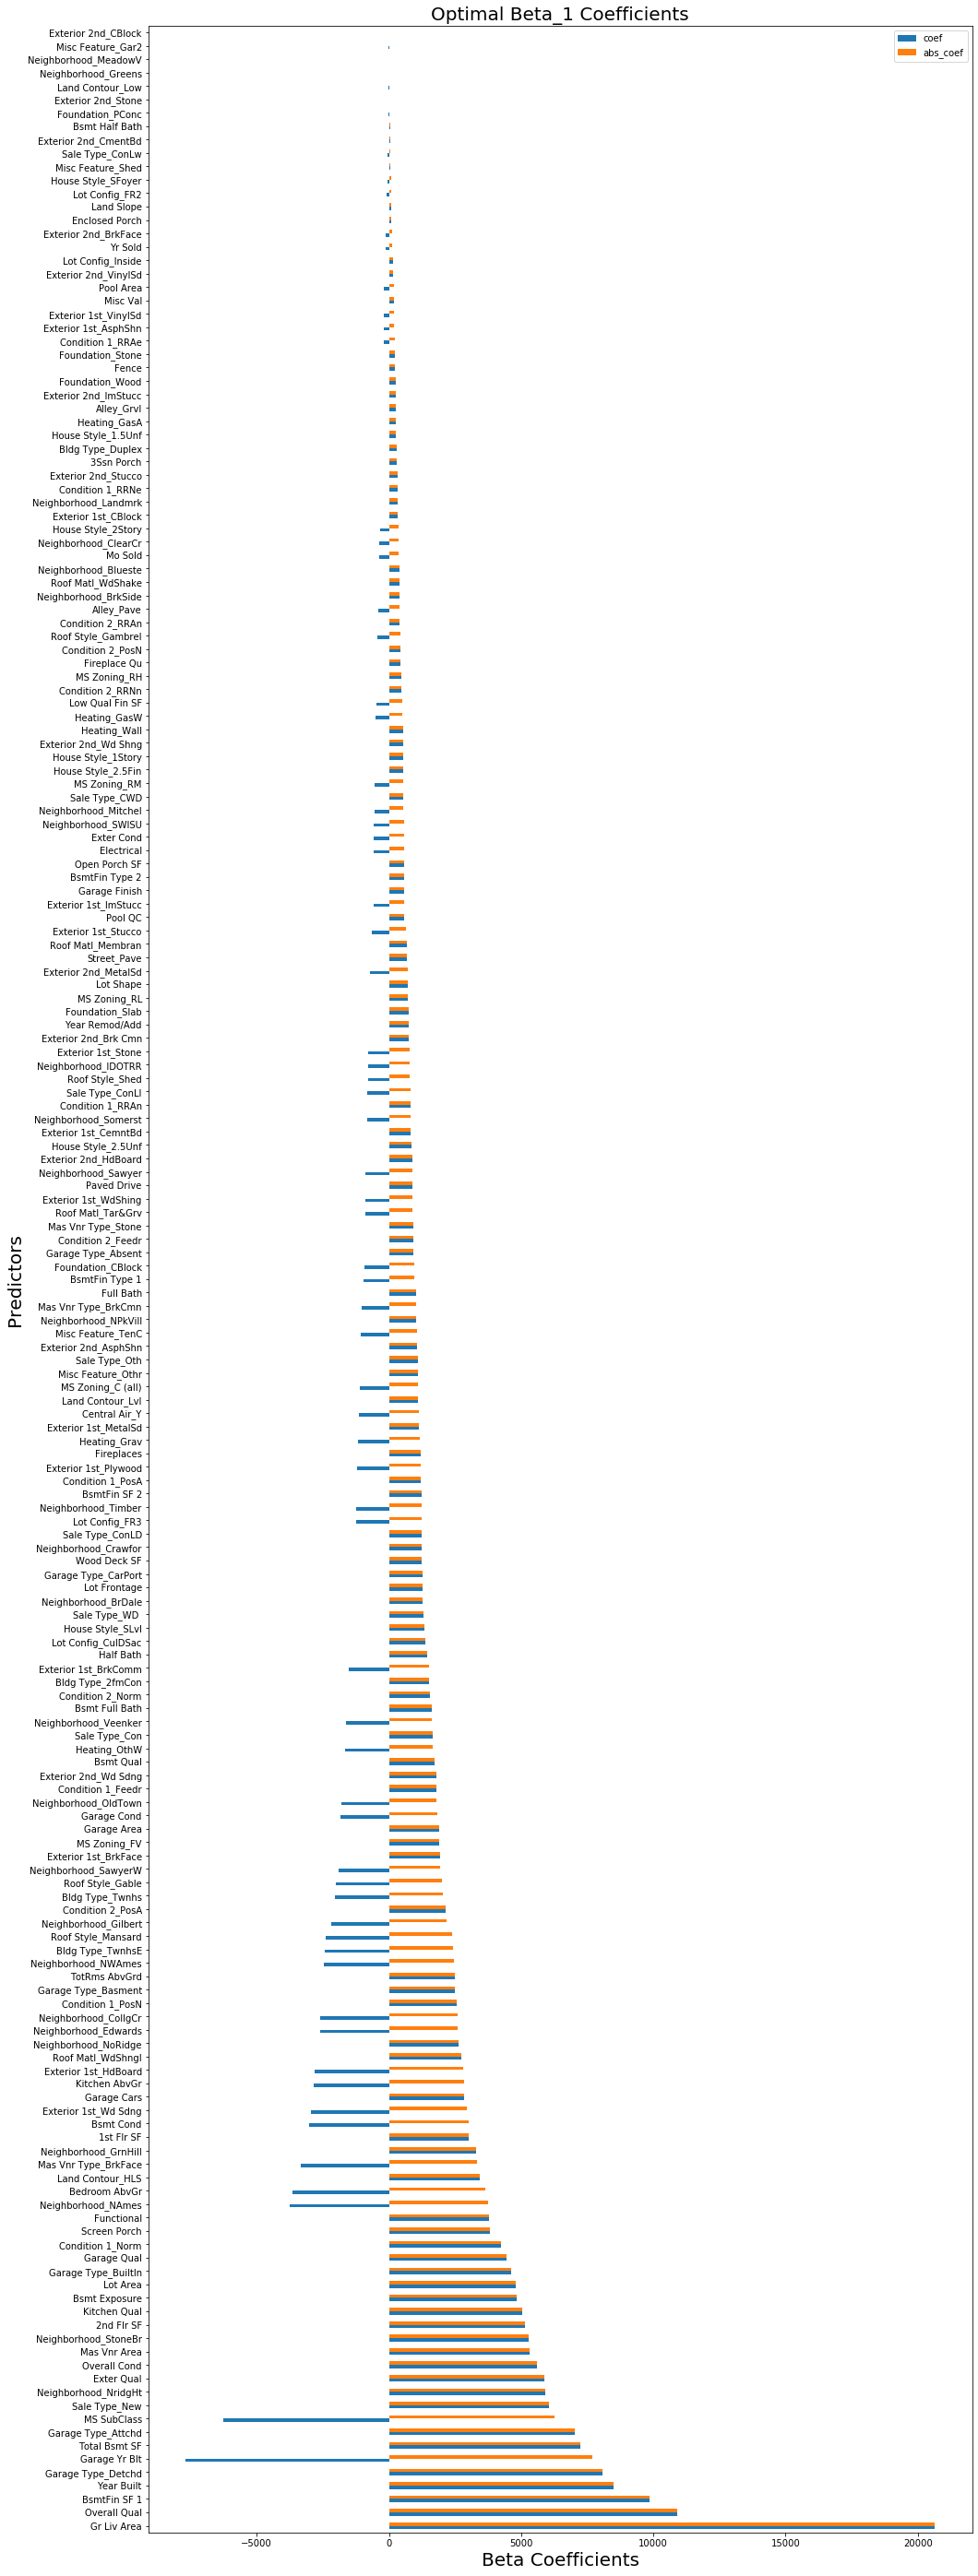

In [86]:
lasso_coef_df = coef_df[coef_df['coef'] != 0].sort_values('abs_coef', ascending = False)
lasso_coef_df.set_index('column', inplace = True)
lasso_coef_df.plot(kind = 'barh', figsize = (16,50))
plt.title('Optimal Beta_1 Coefficients',fontsize = 20);
plt.ylabel('Predictors', fontsize = '20');
plt.xlabel('Beta Coefficients', fontsize = '20');

### Conclusions
The lasso regression was the most efficient model at providing positive relationships due to the nature of the alpha penalty making use of the negative relationships of coefficients as well. With this model, we were able to understand that the best neighborhood for a new housing complex would be Northridge Heights and houses constructed here should have attached garages, larger basements, and other features as is evident by the positive correlation they share with sales price.   

### Linear Regression Kaggle Submission

In [87]:
X_kaggle = df_test[features]

In [88]:
X_kaggle['SalePrice'] = lr.predict(X_kaggle)

In [89]:
output = X_kaggle[['SalePrice']]

In [90]:
output.head()

,SalePrice
Id,
2658,132416.273954
2718,146644.789121
2414,222329.112595
1989,102152.167036
625,171231.686178


In [91]:
output.to_csv('./datasets/first_kaggle_submission.csv')

### Lasso Kaggle Submission

In [92]:
Z_kaggle = ss.transform(X_kaggle.drop(columns = 'SalePrice'))

In [93]:
X_kaggle['SalePrice'] = lasso.predict(Z_kaggle)

In [94]:
output = X_kaggle[['SalePrice']]

In [95]:
output.to_csv('./datasets/lasso_kaggle_submission.csv')

### Sources
- [What is the AMES Housing Authority](https://www.rentalhousingdeals.com/housing-authority/IA/Ames/Ames-Housing-Authority) 
- [Romex vs Knob and Tube](https://www.nachi.org/knob-and-tube.htm)  
- [Ames Housing Data Dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)
